### Libraries import and simple setup

In [2]:
library(openxlsx)
library(ggplot2)
library(dplyr)
library(cowplot)
library(latex2exp)
library(stringr)
library(BBmisc)
library(RColorBrewer)

In [3]:
theme_set(theme_bw()) # theme setup
opt.dpi = 1000 # plots export resolution *.tiff

### 1. Importing and adjusting disintegration data

#### 1.1. reading coefficients for BMP computations

In [4]:
df.coefficients <- read.xlsx("../data/data.xlsx",sheet='coefficients')
df.coefficients$file <- str_trim(gsub(".xml","",df.coefficients$file)) # remove xml suffix from filename

df.coefficients

,file,coefficient
,<chr>,<dbl>
1,report_2019-01-31_1110,2.49
2,report_2019-02-20_0924,2.46
3,report_2019-04-23_1235,2.84
4,report_2019-08-09_1034,2.86
5,report_2019-09-20_1034,2.63
6,report_2019-11-10_1305,2.59


#### 1.2. Reading and adjusting the disintegration dataset

In [5]:
df.dis <- read.xlsx("../data/data.xlsx",sheet='disintegration')

df.dis$table.index <- factor(df.dis$table.index,ordered = TRUE,levels=paste0('tab',1:12))
df.dis$`disintegration.temperature.[oC]` <- factor(df.dis$`disintegration.temperature.[oC]`,ordered = TRUE)
df.dis$report.file <- str_trim(df.dis$report.file)

df.dis.original.col.names <- colnames(df.dis) # just in case
df.dis.simlified.col.names <- c('date','table.index','report.file','time','temp','rs.O2','rs.pH','rs.redox',
                                'rs.conductivity','basicity','bod','cod','vfa','DD','P.PO4','TP','N.NO2',
                                'N.NO3','N.NH4','TN','fermentation.case') 
colnames(df.dis) <- df.dis.simlified.col.names

time.breaks <- unique(df.dis$time)

head(df.dis)

,date,table.index,report.file,time,temp,rs.O2,rs.pH,rs.redox,rs.conductivity,basicity,⋯,cod,vfa,DD,P.PO4,TP,N.NO2,N.NO3,N.NH4,TN,fermentation.case
,<chr>,<ord>,<chr>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,29-31.01.2019,tab1,report_2019-02-20_0924,0,45,0.23,6.94,30.7,2.056,8.0,⋯,1680,661,0.0000000,302.0,319.2,0.19,3.05,85.9,220.0,8
2,29-31.01.2019,tab1,report_2019-02-20_0924,4,45,0.21,7.02,-280.8,3.020,17.6,⋯,1910,368,0.8419974,320.0,327.0,0.02,2.43,152.0,488.3,NA
3,29-31.01.2019,tab1,report_2019-02-20_0924,8,45,0.19,6.99,-300.1,3.290,24.8,⋯,2160,419,1.7572119,351.5,359.5,0.03,2.67,198.0,499.0,NA
4,29-31.01.2019,tab1,report_2019-02-20_0924,12,45,0.25,6.86,-269.0,4.210,60.4,⋯,4380,927,9.8843169,515.0,545.0,0.53,5.18,127.0,562.3,NA
5,29-31.01.2019,tab1,report_2019-02-20_0924,24,45,0.23,6.99,-392.7,4.250,66.0,⋯,5720,1168,14.7898667,494.0,610.0,0.17,3.78,368.0,687.3,9
6,29-31.01.2019,tab1,report_2019-02-20_0924,28,45,0.23,6.42,-184.8,6.470,76.0,⋯,6400,1938,17.2792503,890.0,895.0,0.42,3.96,484.0,699.4,NA


##### 1.2.1. Adjusting the factor labels

In [6]:
fact.temp.old <- c('45','50','55','60')
fact.temp.new <- c('T=45°C','T=50°C','T=55°C','T=60°C')
df.dis$dis.temp.new <- rep(NA,nrow(df.dis))
for (ixf in 1:length(fact.temp.old)){
    df.dis[df.dis$temp == fact.temp.old[ixf],'dis.temp.new'] <- fact.temp.new[ixf]
}
df.dis$dis.temp.new <- factor(df.dis$dis.temp.new,ordered = TRUE,levels=fact.temp.new)

#### 1.3. Reading and adjusting the fermentation dataset
It will be needed later

In [7]:
df.fer <- read.xlsx("../data/data.xlsx",sheet='fermentation')

# adjusting data, creating factors, adjusting data types, etc.
df.fer$`Volume.[Nml]` <- as.numeric(df.fer$`Volume.[Nml]`) # some text artifacts are present so as.numeric has to be used
df.fer$`disintegration.temp.[oC]` <- factor(df.fer$`disintegration.temp.[oC]`,
                                            ordered=TRUE, levels=c('in.','b.d.','45','50','55','60'))
df.fer$`disintegration.time.[h]` <- factor(df.fer$`disintegration.time.[h]`,
                                           ordered=TRUE,levels=c('in.','0','24','48'))

# creating new factor to distinguish between case No and experiment included in a case
df.fer$case.exp <- factor(paste(df.fer$case.No, df.fer$experiment.No,sep='-'))


# changing the column names for simpler manipulation
df.fer.original.col.names <- colnames(df.fer) # just in case
df.fer.simlified.col.names <- c('day','volume','original.column.header','description','composition','inoculum.weight',
                                'co-substrate.weight','dis.temp','dis.time','case','experiment','disintegration.tab','case.exp')

colnames(df.fer) <- df.fer.simlified.col.names

# removing one series - it turned out to be invalid
bad.series_case.exp <- '35-1' # it will be removed in some analyses
df.fer <- df.fer[df.fer$case.exp != bad.series_case.exp,]

df.fer$sample.type <- paste(df.fer$dis.temp,df.fer$dis.time,sep="/")
                             
#manually
fact.old <- c('in./in.','b.d./0', '45/24', '45/48', '50/24', '50/48', '55/24', '55/48', '60/24', '60/48')
fact.new <- c('INC','INC+WAS', 'INC+45/24WAS', 'INC+45/48WAS', 'INC+50/24WAS', 'INC+50/48WAS', 'INC+55/24WAS', 
              'INC+55/48WAS', 'INC+60/24WAS', 'INC+60/48WAS')
                             
for (ixf in 1:length(fact.old)){
    df.fer[df.fer$sample.type == fact.old[ixf],'sample.type'] <- fact.new[ixf]
}

df.fer$sample.type <- factor(df.fer$sample.type,ordered=TRUE, levels=fact.new)


fact.temp.old <- c('in.','b.d.','45','50','55','60')
fact.temp.new <- c('INC','INC+WAS','T=45°C','T=50°C','T=55°C','T=60°C')
df.fer$dis.temp.new <- rep(NA,nrow(df.fer))
for (ixf in 1:length(fact.temp.old)){
    df.fer[df.fer$dis.temp == fact.temp.old[ixf],'dis.temp.new'] <- fact.temp.new[ixf]
}
df.fer$dis.temp.new <- factor(df.fer$dis.temp.new,ordered = TRUE,levels=fact.temp.new)

fact.time.old <- c('in.','0','24','48')
fact.time.new <- c('INC','INC+WAS','t=24h','t=48h')
df.fer$dis.time.new <- rep(NA,nrow(df.fer))
for (ixf in 1:length(fact.time.old)){
    df.fer[df.fer$dis.time == fact.time.old[ixf],'dis.time.new'] <- fact.time.new[ixf]
}
df.fer$dis.time.new <- factor(df.fer$dis.time.new,ordered = TRUE,levels = fact.time.new)

#### 1.4. Setting colors for factors display

In [8]:
temp.colors <- c(`INC`='grey48',`INC+WAS`='grey23',`T=45°C`='gold3',`T=50°C`='orangered',`T=55°C`='deeppink1',`T=60°C`='chocolate4')
temp.new.colors <- temp.colors

### 2. Analysis

#### 2.1. Time series plots of disintegration process

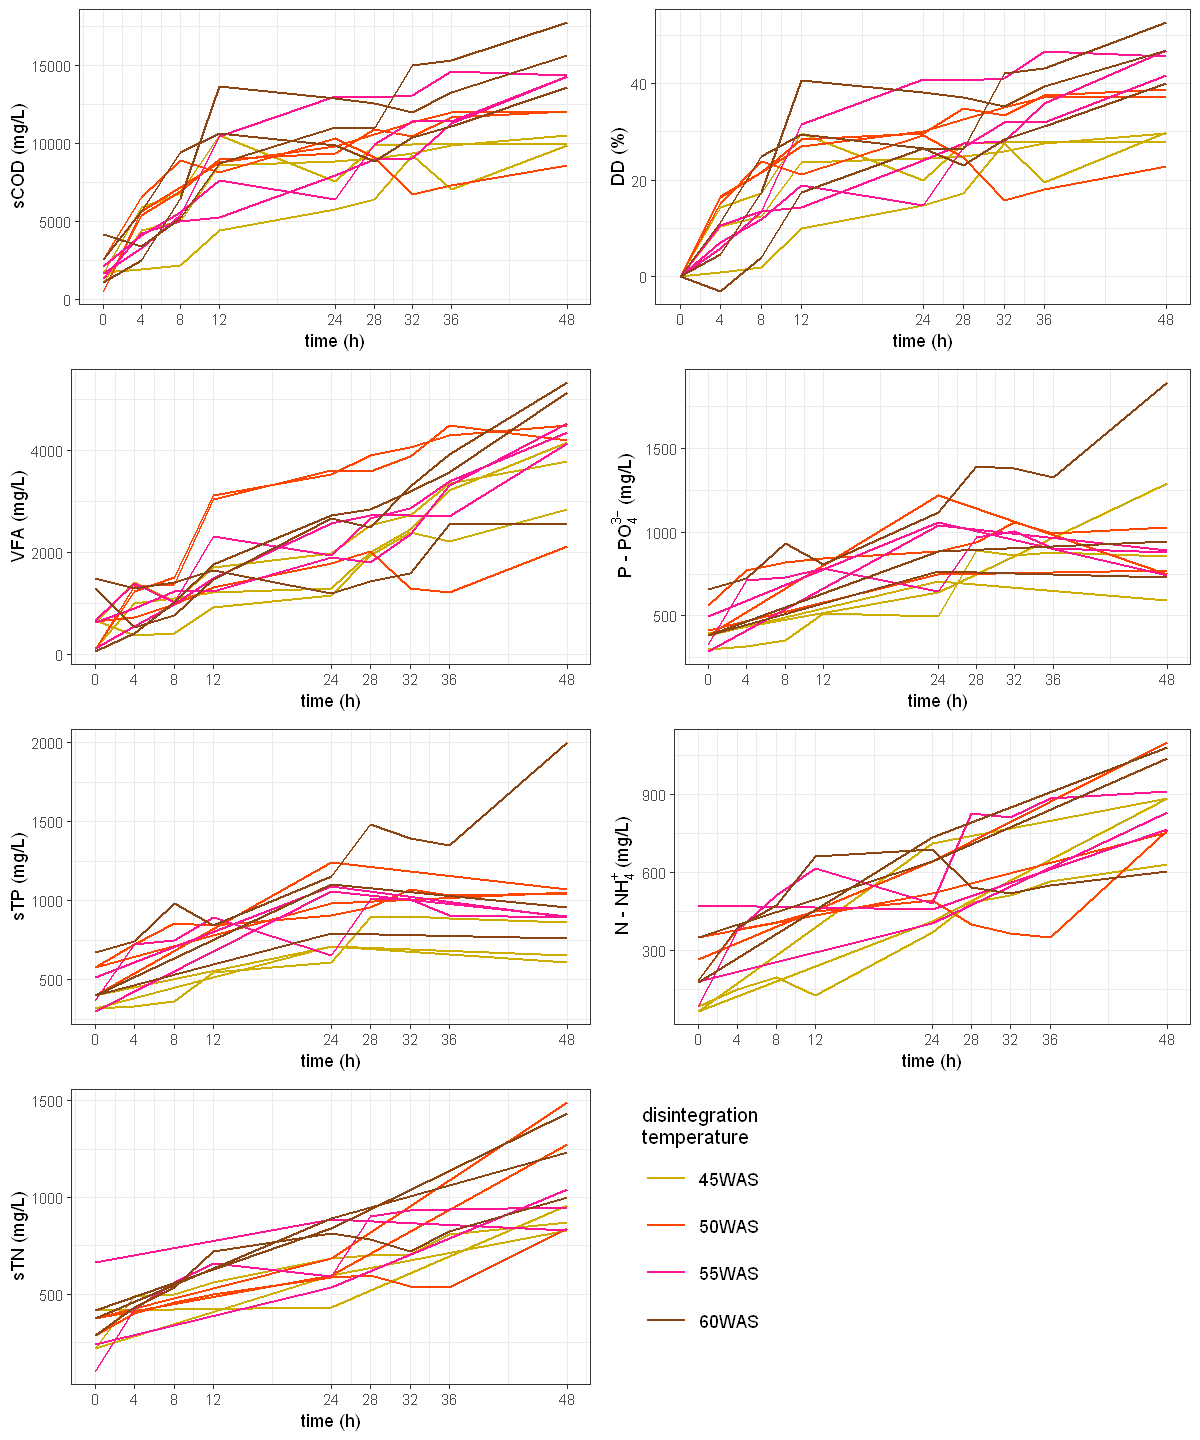

In [9]:
options(repr.plot.height=12,repr.plot.width=10)

featy <- 'cod'
p1 <- ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),
             aes(x=time,y=.data[[featy]],color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       scale_color_manual(values = temp.new.colors, name = "disintegration\ntemperature [C]") +
       scale_x_continuous(breaks = time.breaks) + theme(legend.position = 'none') +
       xlab("time (h)") + ylab("sCOD (mg/L)")

featy <- 'DD'
p2 <- ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),aes(x=time,y=.data[[featy]],color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       scale_color_manual(values = temp.new.colors, name = "disintegration\ntemperature [C]") +
       scale_x_continuous(breaks = time.breaks) + theme(legend.position = 'none') +
       xlab("time (h)") + ylab("DD (%)")  

featy <- 'vfa'
p3 <- ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),aes(x=time,y=.data[[featy]],color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       scale_color_manual(values = temp.new.colors, name = "disintegration\ntemperature [C]") +
       scale_x_continuous(breaks = time.breaks) + theme(legend.position = 'none')+
       xlab("time (h)") + ylab("VFA (mg/L)")

featy <- 'P.PO4'
p4 <- ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),aes(x=time,y=.data[[featy]],color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       scale_color_manual(values = temp.new.colors, name = "disintegration\ntemperature [C]") +
       scale_x_continuous(breaks = time.breaks) + theme(legend.position = 'none') +
       xlab("time (h)") + ylab(TeX("P - PO$_4^{3-}$ (mg/L)"))

featy <- 'TP'
p5 <- ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),aes(x=time,y=.data[[featy]],color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       scale_color_manual(values = temp.new.colors, name = "disintegration\ntemperature [C]") +
       scale_x_continuous(breaks = time.breaks) + theme(legend.position = 'none') +
       xlab("time (h)") + ylab("sTP (mg/L)")

featy <- 'N.NH4'
p6 <- ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),aes(x=time,y=.data[[featy]],color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       scale_color_manual(values = temp.new.colors, name = "disintegration\ntemperature [C]") +
       scale_x_continuous(breaks = time.breaks) + theme(legend.position = 'none') +
       xlab("time (h)") + ylab(TeX("N - NH$_4^+$ (mg/L)"))

featy <- 'TN'
p7 <- ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),aes(x=time,y=.data[[featy]],color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       scale_color_manual(values = temp.new.colors, name = "disintegration\ntemperature [C]") +
       scale_x_continuous(breaks = time.breaks) + theme(legend.position = 'none')+
       xlab("time (h)") + ylab("sTN (mg/L)")

legend <- get_legend(
  # create some space to the left of the legend
  ggplot(na.omit(df.dis[c('time',featy,'table.index','dis.temp.new')]),aes(x=time,y=.data[[featy]],
                                                                                           color=dis.temp.new,group=table.index)) + geom_path(linewidth=0.7) + 
       # there is a workaround as drop argument does not what it is supposed to
       scale_color_manual(values = temp.new.colors[3:length(temp.new.colors)], name = "disintegration\ntemperature",drop=TRUE,
                         labels = c("45WAS","50WAS","55WAS","60WAS")) +
    
       scale_x_continuous(breaks = time.breaks)  +   
       theme(legend.key.size = unit(1, 'cm'), #change legend key linewidth
             legend.key.height = unit(1, 'cm'), #change legend key height
             legend.key.width = unit(1, 'cm'), #change legend key width
             legend.title = element_text(size=12), #change legend title font linewidth
             legend.text = element_text(size=11),
             legend.position=c(0.17, 0.6))
)
plot_grid(p1,p2,
          p3,p4,
          p5,p6,
          p7,legend,ncol=2)
# ggsave("IMG/paper/rev2/Figure1.tiff",dpi=opt.dpi, width = 10, height = 12,compression = "lzw")

#### 2.2. Cluster analysis of disintegration data

##### 2.2.1. Determining the mean value of the produced methane for samples pretreated in similar conditions

In [10]:
df.fer.end.mean <- df.fer %>%
              select(day, volume, case,experiment,dis.time.new,dis.temp.new,sample.type) %>%
                 group_by(case,experiment) %>%
                    filter(day == max(day)) %>% 
                      ungroup() %>% 
                        group_by(case,sample.type) %>% 
                            summarise(mean.volume=mean(volume))

head(df.fer.end.mean)

`summarise()` has grouped output by 'case'. You can override using the
`.groups` argument.


case,sample.type,mean.volume
<dbl>,<ord>,<dbl>
1,INC,321.9000
2,INC+WAS,597.0500
3,INC+50/24WAS,656.3500
4,INC+55/24WAS,695.4500
5,INC+50/48WAS,705.3667
6,INC+55/48WAS,716.1667


##### 2.2.2. Merging (inner join) the datasets to get tme mean values of produced $CH_4$ correspomnding to cases and disintegration tables

In [11]:
cases.tabs.df <- merge(
                        merge(df.dis[!is.na(df.dis$fermentation.case),],
                              df.coefficients,by.x='report.file',by.y='file'),
                        df.fer.end.mean,by.x='fermentation.case',by.y='case'
                       )
head(cases.tabs.df)

,fermentation.case,report.file,date,table.index,time,temp,rs.O2,rs.pH,rs.redox,rs.conductivity,⋯,P.PO4,TP,N.NO2,N.NO3,N.NH4,TN,dis.temp.new,coefficient,sample.type,mean.volume
,<dbl>,<chr>,<chr>,<ord>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>,<ord>,<dbl>
1,2,report_2019-01-31_1110,8-10.01.2019,tab6,0,50,0.22,6.70,84.2,3.180,⋯,411,575.0,0.18,3.47,264.2,374.4,T=50°C,2.49,INC+WAS,597.0500
2,2,report_2019-01-31_1110,8-10.01.2019,tab7,0,55,0.19,6.94,30.7,2.056,⋯,332,366.3,0.19,3.05,85.9,102.3,T=55°C,2.49,INC+WAS,597.0500
3,3,report_2019-01-31_1110,8-10.01.2019,tab6,24,50,0.19,6.42,-133.2,7.040,⋯,750,980.0,0.40,5.12,640.0,686.0,T=50°C,2.49,INC+50/24WAS,656.3500
4,4,report_2019-01-31_1110,8-10.01.2019,tab7,24,55,0.20,6.59,-105.0,6.240,⋯,647,650.0,0.15,4.49,482.0,590.3,T=55°C,2.49,INC+55/24WAS,695.4500
5,5,report_2019-01-31_1110,8-10.01.2019,tab6,48,50,0.20,6.26,-104.3,9.080,⋯,769,1050.0,0.25,13.90,1098.0,1490.0,T=50°C,2.49,INC+50/48WAS,705.3667
6,6,report_2019-01-31_1110,8-10.01.2019,tab7,48,55,0.21,6.52,-119.1,10.830,⋯,877,890.0,0.41,10.14,910.0,950.0,T=55°C,2.49,INC+55/48WAS,716.1667


##### 2.2.3. Creating clustering tree for features vs. sample types

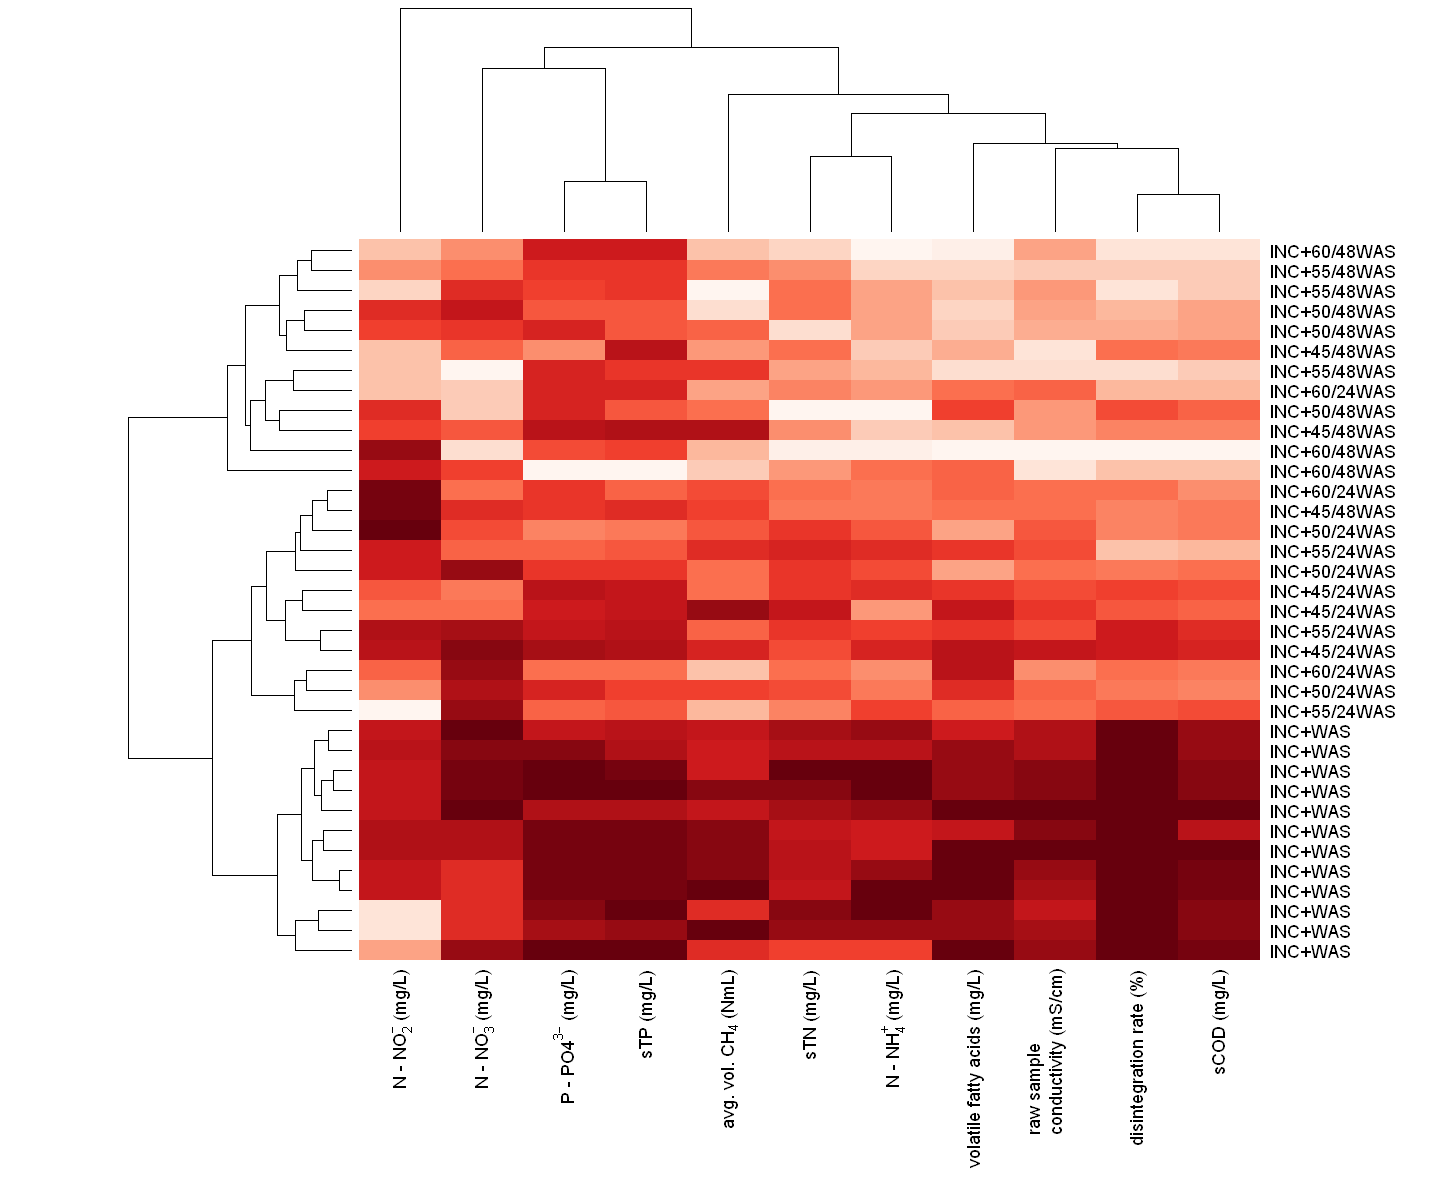

In [12]:
options(repr.plot.width=12, repr.plot.height=10)

hclust.feat <-  c('sample.type','rs.conductivity','cod',
                  'vfa','DD','P.PO4','TP','N.NO2','N.NO3','N.NH4','TN',"mean.volume")

# features used for creating the clusters
clustering.feat <-  c('rs.conductivity','cod',
                       'vfa','DD','P.PO4','TP','N.NO2','N.NO3','N.NH4','TN',"mean.volume")

col.labels <- c('raw sample\nconductivity (mS/cm)','sCOD (mg/L)',
                'volatile fatty acids (mg/L)','disintegration rate (%)',
                TeX('P - PO4$^{3-}$ (mg/L)'),'sTP (mg/L)',TeX('N - NO$_2^-$ (mg/L)'),
                TeX('N - NO$_3^-$ (mg/L)'),TeX('N - NH$_4^+$ (mg/L)'),'sTN (mg/L)',
                TeX("avg. vol. $CH_4$ (NmL)"))

clust.df <- cases.tabs.df[hclust.feat]

row.names(clust.df) <- paste(1:nrow(cases.tabs.df),'. ',clust.df$sample.type,sep="")
sample.type <- as.character(clust.df$sample.type)

heatmap(as.matrix(normalize(clust.df[clustering.feat],method='range')), scale = "none",symm=FALSE, 
        labCol=col.labels,labRow=sample.type,margins=c(12,3),cexCol=1.1,cexRow = 1.1,
        col= rev(colorRampPalette(brewer.pal(9, "Reds"))(32)))

##### 2.2.4. Creating clustering tree for distances between sample types

Warning message in dist(clust.df):
"NAs introduced by coercion"


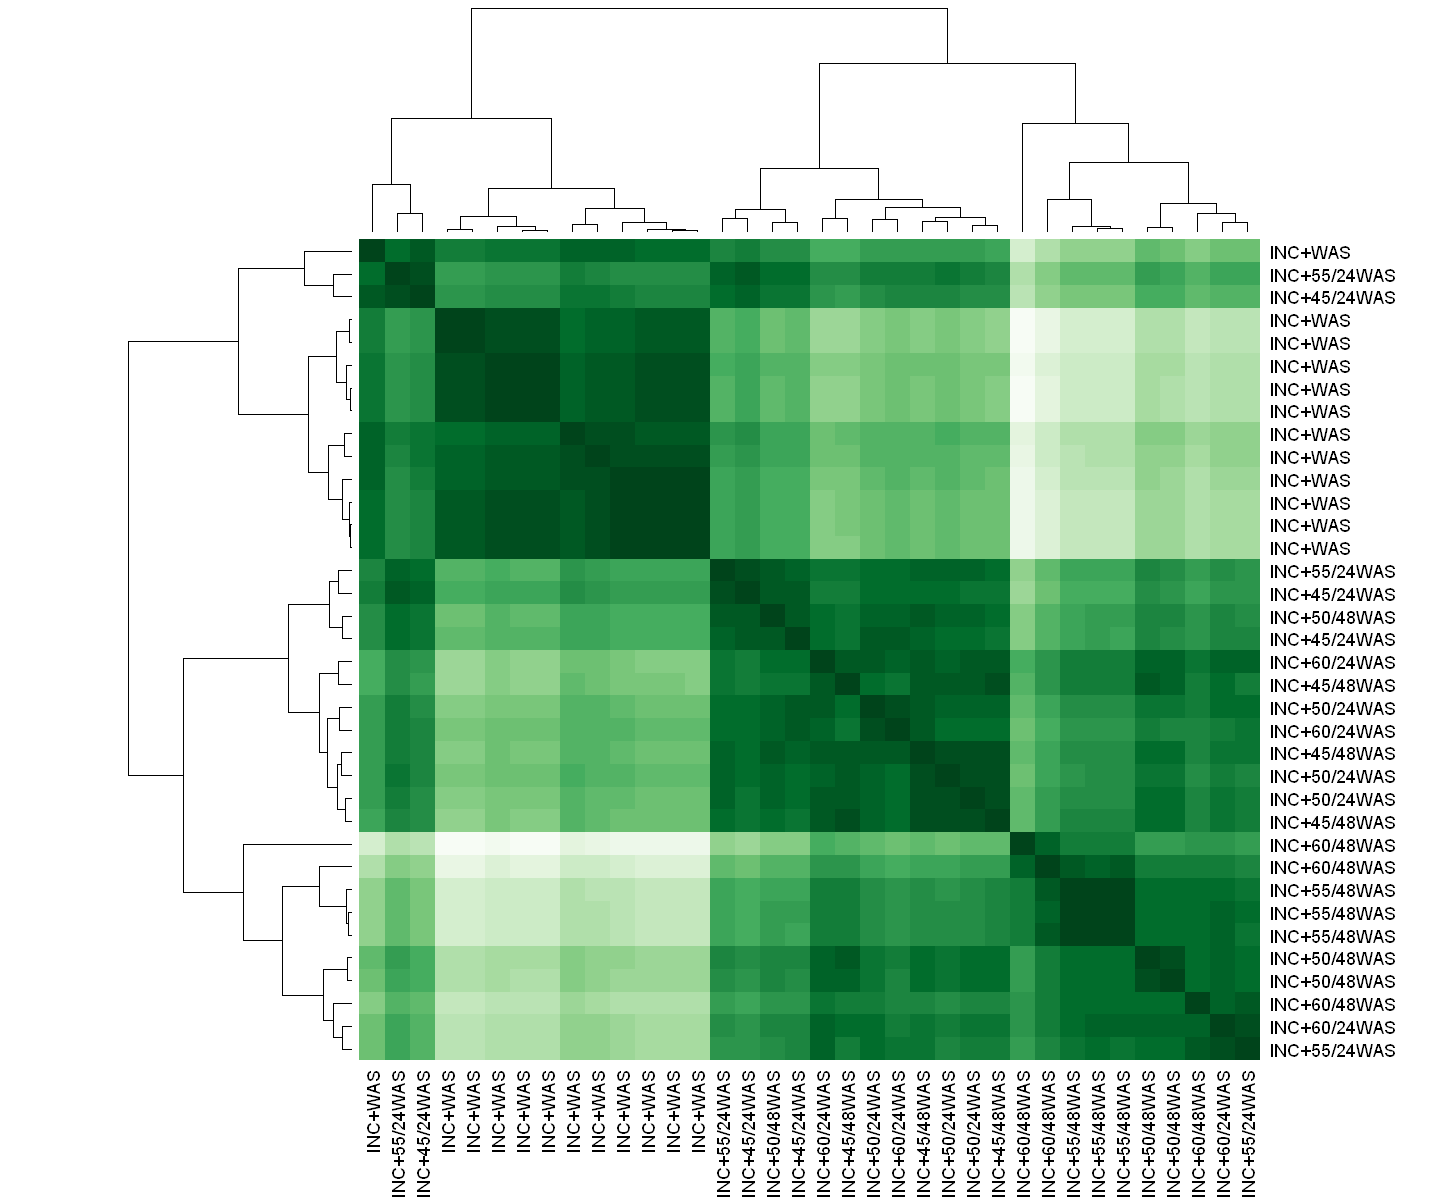

In [13]:
options(repr.plot.width=12, repr.plot.height=10)

hclust.feat <-  c('rs.conductivity','cod',
                  'vfa','DD','P.PO4','TP','N.NO2','N.NO3','N.NH4','TN',"mean.volume")

heatmap(as.matrix(dist(clust.df)), scale = "none",
        labCol=sample.type,labRow=sample.type,revC=TRUE,cexCol=1.1,cexRow = 1.1, margins=c(7,3),
        col= rev(colorRampPalette(brewer.pal(9, "Greens"))(32)))

In [14]:
df.energy <- read.xlsx("../data/Energy_R3_figures_7-8.xlsx",sheet='R_prepared_long')

temp.levels <- c("37°C (AD)", "45°C", "50°C", "55°C", "60°C", "45°C (HEX)", "50°C (HEX)", "55°C (HEX)", "60°C (HEX)")
df.energy$Temp <- factor(df.energy$Temp,ordered = TRUE, levels = temp.levels)
df.energy$type <- factor(df.energy$type,ordered=TRUE,levels=rev(c("total energy", "electricity", "heat","Net total LT-PT+AD - net AD")))

head(df.energy)

,data,Temp,value,type.full,type,comment
,<chr>,<ord>,<dbl>,<chr>,<ord>,<chr>
1,fig7a,45°C,-0.4899856,Net heat,heat,Without heat recovery in LT-PT
2,fig7a,50°C,-1.3483991,Net heat,heat,Without heat recovery in LT-PT
3,fig7a,55°C,-1.9513926,Net heat,heat,Without heat recovery in LT-PT
4,fig7a,60°C,-1.8257461,Net heat,heat,Without heat recovery in LT-PT
5,fig7a,45°C (HEX),0.2047676,Net heat,heat,With heat recovery in LT-PT
6,fig7a,50°C (HEX),-0.2194252,Net heat,heat,With heat recovery in LT-PT


In [15]:
tmp.df <- df.energy[df.energy$data=="fig7a",]

plot7a <- ggplot(tmp.df,aes(x=value,y=Temp,fill=type)) + 
          geom_bar(stat="identity",position=position_dodge(),width = 0.75,color="black") + geom_vline(xintercept = 0,linewidth=0.5) +
          scale_fill_manual(values = c('total energy'="red", 'electricity'="blue", 'heat'="green","Net total LT-PT+AD - net AD"="chocolate1")) +
          scale_x_continuous(TeX("\\Delta E$_{p} $ $(MJ/kg $ VS$)"), seq(-2.5,1.5,0.5), seq(-2.5,1.5,0.5),limits=c(-2.25,1.25)) + 
          ylab("") +
          theme(legend.position="bottom",
                axis.text= element_text(linewidth=12),
                axis.title=element_text(linewidth=14,face="bold"),
                legend.text=element_text(linewidth=14)) +
          guides(fill=guide_legend(title=""))

plot7a

ERROR: Error in element_text(linewidth = 14, face = "bold"): unused argument (linewidth = 14)


In [ ]:
tmp.df <- df.energy[df.energy$data=="fig7b",]

plot7b <- ggplot(tmp.df,aes(x=value,y=Temp,fill=type)) + 
          geom_bar(stat="identity",position=position_dodge(),width = 0.75,color="black") + geom_vline(xintercept = 0,linewidth=0.5) +
          scale_fill_manual(values = c('total energy'="red", 'electricity'="blue", 'heat'="green","Net total LT-PT+AD - net AD"="chocolate1")) +
          scale_x_continuous(TeX("\\Delta E$_{p} $ $(MJ/kg $ VS$)"), seq(-2.5,1.5,0.5), seq(-2.5,1.5,0.5),limits=c(-2.25,1.25)) +  
          ylab("") +xlab(TeX("\\Delta E$_{p} $ $(MJ/kg $ VS$)")) +
          theme(legend.position="bottom",
                axis.text= element_text(linewidth=12),
                axis.title=element_text(linewidth=14,face="bold"),
                legend.text=element_text(linewidth=14)) +
          guides(fill=guide_legend(title=""))

plot7b

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)
pg <- plot_grid(plot7a, plot7b,
                nrow=1,ncol=2,labels=c('(a)','(b)', label_linewidth = 14))
pg

ggsave(plot=pg,"IMG/paper/rev2/Figure7.tiff",dpi=opt.dpi, width = 12, height = 6,compression = "lzw")

In [ ]:
tmp.df <- df.energy[df.energy$data=="fig8a",]

plot8a <- ggplot(tmp.df,aes(x=value,y=Temp,fill=type)) + 
          geom_bar(stat="identity",position=position_dodge(),width = 0.75,color="black") + geom_vline(xintercept = 0,linewidth=0.5) +
          scale_fill_manual(values = c('total energy'="red", 'electricity'="blue", 'heat'="green","Net total LT-PT+AD - net AD"="chocolate1")) +
          scale_x_continuous(TeX("\\Delta E$_{D},$ \\Delta E$_{PD} $ $(MJ/kg $ VS$)"), seq(-2,3.0,0.5), seq(-2,3.0,0.5),) +  
          ylab("") +
          theme(legend.position="bottom",
                axis.text= element_text(linewidth=12),
                axis.title=element_text(linewidth=14,face="bold"),
                legend.text=element_text(linewidth=14)) +
          guides(fill=guide_legend(title=""))

plot8a

In [ ]:
tmp.df <- df.energy[df.energy$data=="fig8b",]

plot8b <- ggplot(tmp.df,aes(x=value*100,y=Temp,fill=type)) + 
          geom_bar(stat="identity",position=position_dodge(),width = 0.25,color="black") + geom_vline(xintercept = 0,linewidth=0.5) +
          scale_fill_manual(values = c('total energy'="red", 'electricity'="blue", 'heat'="green","Net total LT-PT+AD - net AD"="chocolate1")) +
          scale_x_continuous(TeX("e$_r $ $($%$)"), seq(-100,100,25), seq(-100,100,25),limits=c(-75,75)) +  
          ylab("") +
          theme(legend.position="bottom",
                axis.text= element_text(linewidth=12),
                axis.title=element_text(linewidth=14,face="bold"),
                legend.text=element_text(linewidth=14)) +
          guides(fill=guide_legend(title=""))

plot8b

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)
pg <- plot_grid(plot8a, plot8b,
                nrow=1,ncol=2,labels=c('(a)','(b)', label_linewidth = 14))
pg

ggsave(plot=pg,"IMG/paper/rev2/Figure8.tiff",dpi=opt.dpi, width = 12, height = 6,compression = "lzw")